# Automatic Elon Musk: Text Generation with LSTM

Text Gen using a character-level LSTM network

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

In [2]:
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
%cd ..
%cd gdrive/MyDrive/elon_bot

/
/gdrive/MyDrive/elon_bot


## Preprocessing

In [4]:
# 2020 01 ~ 12
elon_df = pd.read_csv('elon_tweets.csv')
elon_df.head()

,username,id,text,createdtime,num_of_retweets,hashtags
0,elonmusk,1.341096e+18,@LizClaman @Tesla @FoxBusiness @ClamanCountdow...,2020-12-21 19:00:31,11.0,[]
1,elonmusk,1.341007e+18,Thanks to everyone who worked so hard to make ...,2020-12-21 13:04:16,7595.0,[]
2,elonmusk,1.341006e+18,@teslaownerssv Indeed,2020-12-21 13:02:48,79.0,[]
3,elonmusk,1.340981e+18,@Kristennetten It was a seriously twisted affa...,2020-12-21 11:21:24,86.0,[]
4,elonmusk,1.340979e+18,"@MKBHD They are, although it’s kind low-key. T...",2020-12-21 11:13:27,715.0,[]


In [5]:
# 2012 ~ 2017
elon_2012 = pd.read_csv('data_elonmusk.csv', encoding= 'unicode_escape')
elon_2012.head()

,row ID,Tweet,Time,Retweet from,User
0,Row0,@MeltingIce Assuming max acceleration of 2 to ...,2017-09-29 17:39:19,NaN,elonmusk
1,Row1,RT @SpaceX: BFR is capable of transporting sat...,2017-09-29 10:44:54,SpaceX,elonmusk
2,Row2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Row3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Row4,Fly to most places on Earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


In [6]:
tweets_2012 = elon_2012.Tweet

# remove retweets
retweet = ['RT']
tweets_2012 = tweets_2012[~tweets_2012.str.contains('|'.join(retweet))]
len(tweets_2012)

2690

In [7]:
# manually scraped tweets
tweets_2019 = ['Was up all night with SpaceX team working on Starship tank dome production (most difficult part of primary structure). Dawn arrives …',
              'Almost three now. Boca team is crushing it! Starship has giant dome Rolling on the floor',
              'Turn on auto navigate feature & car will activate traffic-based navigation to work, home or calendar, depending on context, as soon as you sit down. No input required at all.',
              'Just swipe down on Tesla nav button for car to automatically navigate to home, work or destination in calendar',
              'stock art', 'Whoa … the stock is so high lol', 'Just looked at my wiki for 1st time in years. It’s insane! Btw, can someone please delete “investor”. I do basically zero investing.',
              'If Tesla & SpaceX go bankrupt, so will I. As it should be.', 'The real reason for Looper was to travel back in time & stop a terrible calamity — the premiere of Cats!',
              'Pre VFX cut would be $$$$', 'Tesla holiday software update has FSD sneak preview, Stardew Valley, Lost Backgammon & a few other things',
              'You don’t hear much about element 43', 'Tesla Moth Mode (better late than never)',
              'Never trust cynics, as they excuse their own bad deeds by telling themselves everyone does it',
              'If life is a video game, the graphics are great, but the plot is confusing & the tutorial is way too long',
              'Games only render what you look at when you look at it, as the compute load would otherwise be impossibly high. Until observed, objects are a probability function, aka quantum mechanics.',
              'smol ∩ puppy ∩ math', 'Root of energy to mass ratio is max render speed of the simulation',
              'Meant to say “is render speed”. Frame rate is locked.', 'Way too many paywalls & spawn points',
              'Just Read the Instructions', 'Kids these days have no respect!', 'Math jokes have a small audience',
              'Huge thanks to everyone who contributed ideas to Cybertruck. It’s better because of you!',
              'Speed solves everything', 'Franz throws steel ball at Cybertruck window right before launch. Guess we have some improvements to make before production haha.',
              'People often think they’re breathing oxygen, but are actually breathing nitrogen (78%) with a side serving of oxygen (21%) in argon sauce (1%), spiced up with CO2, H2O & a dash of neon & krypton (etc.)',
               'nobody *expects* the Cybertruck', '146k Cybertruck orders so far, with 42% choosing dual, 41% tri & 17% single motor',
              'Hydrogen is a light, odorless gas, which, given enough time, turns into people who will make this statement',
              'Tesla Cybertruck (pressurized edition) will be official truck of Mars', 'Cybertruck is our last product unveil for a while, but there will be some (mostly) unexpected technology announcements next year',
               'Reason Cybertruck is so planar is that you can’t stamp ultra-hard 30X steel, because it breaks the stamping press', 
               'Bring it on', '78% of people want to gentrify Mordor', 'National Science Foundation, u should add a W to ur name. Would get way more clicks. Ur welcome.',
               '200k', 'http://x.com/x', 'Sandwich time travel is the only explanation', 'For Treebeard', 'If you’re directly affected by wildfire power outages, Tesla is reducing Solar+Powerwall prices by $1000 as of today',
               'Took my son to play piano for the seniors home in Pasadena. It was lovely to see them smile', 'Maybe call Tesla solar roof tiles product Solarglass? Like Dragonglass, but solar!',
               'Congrats to Tesla team on Model 3 winning best midsize car in Germany!', 'Gentrify Mordor?', 'Some secrets are too dangerous to be free',
               'Rage, rage against the dying of the light', 'Um @Porsche, this word Turbo does not mean what you think it does', 
               'Starship will allow us to inhabit other worlds', 'Told you AI was dangerous!!', 'If advanced AI (beyond basic bots) hasn’t been applied to manipulate social media, it won’t be long before it is',
               'Might make sense to have thousands of solar reflector satellites 🛰 to warm Mars vs artificial suns (tbd)',
               'Model S just set record for fastest 4 door ever at Laguna Seca, video tmrw', 'The only thing beyond Ludicrous is Plaid',
               'Area 51 of Area 51', 'And flights of angels sing thee to thy rest', 'Probability that we’re in base Polytopia is highly unlikely - KWM',
               'Hadouken!!', 'Technically, alcohol is a solution', 'To Infinity and Beyond!', 'SpaceX has Area 59', 'I am become meme', 
               'Falcon rocket reentry from space with double sonic booms', "“If you dislike change, you're going to dislike irrelevance even more.” — Gen Shinseki",
               'Neuralink surprise twist!', 'Ability to stream YouTube & Netflix when car is stopped coming to your Tesla soon! Has an amazingly immersive, cinematic feel due to the comfy seats & surround sound audio.',
               'Accelerating Starship development to build the Martian Technocracy', 'Starhopper flight successful. Water towers *can* fly haha!!',
               'Dr. Livingstone, I presume?', 'Meme of recursive irony', 'Yep, order online at http://Tesla.com in 2 mins & car delivered direct to home',
               'Typing Merlin literally just autocorrected me to merkin', 'Tesla owners can schedule service appointments in under a minute just using their Tesla phone app!',
               'Tesla is going to develop a quiet, electric leafblower', 'Happy Home Planet Day!', 'Turns out there’s more ways to use Autopilot than we imagined',
               'Changing Tesla horn sound to Goat', 'Ethereum', 'My Twitter is pretty much complete nonsense at this point',
              'The Internet is insane', 'Thinking about adding giant stainless steel dragon wings to Starship',
              '“Wake up sheeple!” - sheep', 'Back to work …', 
               'Please support my campaign to rebrand @WSJ as Socks emoji!', 'When you read double standard articles about Tesla, please ask why. Maybe there’s a good reason that isn’t obvious.',
              'Please note that the price of the Tesla Full Self-Driving option will increase substantially over time', 
              'Bach is killing it on YouTube', 'At some point, @TheOnion and I should just a get a room …',
              'Buying a car in 2019 that can’t upgrade to full self-driving is like buying a horse instead of a car in 1919',
              'Static fire data looks good so far. This is first launch of Falcon Heavy Block 5, so we’re being extra cautious. Launch date might move.',
              'Dogecoin value may vary', 'Dogecoin rulz', 'Host meme review?', 'tbh smh', 'Just bought http://stankmemes.com oh yeah',
              'ET phone home. No answer', 'LA is so beautiful after the rain', 'If heat death will be inevitable end of Universe, it actually *is* all about journey',
               'Fate *loves* irony. Frankly, too much.', 'Tap Tesla logo at top of your car’s touchscreen & wait 10 secs to open special features box',
               'Thursday 2pm', 'Make the Mars Technocracy real', 'Sending this tweet through space via Starlink satellite 🛰',
               'But actually …', 'the color orange is named after the fruit', 'Haha', 'And the lead character is also named Woody',
               'Space Jam should’ve won the Oscar', 'Why is there no emoji for dignity!!', 'Srsly', 'Going offline for a few days',
               'Is Space Jam good?', 'Inside Starship cargo bay. Header tanks mounted in tip of nosecone to offset engine weight at rear.',
               'Tesla Q3 results: - Shanghai Giga ahead of schedule - Model Y ahead of schedule - Solar installs +48% from Q2 - GAAP profitable - Positive free cash flow',
               'French fries French fries are the devil Smiling face with horns', 'More carrot, less stick', 'So much respect for those doing high volume manufacturing. It’s insanely hard, but you make a real thing that people value. My hat is off to you …',
               'Tesla software V10.0 comes with karaoke Microphone', 'Excited about launching @NASA asteroid defense mission!',
               'Thank for helping grow sustainable energy through solar!', 'All Tesla Supercharger stations in regions affected by California power outages will have Tesla Powerpacks within next few weeks. Just waiting on permits.',
               'Soon, SpaceX will launch @NASA atronauts to @Space_Station!', 'Customized horn & movement sounds (coconuts being one, of course) coming to Teslas soon',
               'Tesla wins best headlights award First place medal', 'Over 550,000 Tesla Smart Summon uses in first few days!',
               'Tesla Solar Tile Roof V3 launch tomorrow at 2pm', 'Given how quickly the world is shifting to electric vehicles, a gas/diesel vehicle bought today will probably have low resale value',
               'Get Tesla Solar plus Powerwall battery for 24/7 clean power & no more blackouts! http://Tesla.com/solar', 'Apologies to those waiting for Solar/Powerwall outside California, as we are prioritizing those affected by wildfires',
               'Tesla Solarglass roof', 'Ms. Chief & Ms. Tree', 'Homes with solar sell for 4.1% more, according to Zillow. Adding a Powerwall battery is highly likely to increase home value too imo, as security against blackouts is increasingly important. https://zillow.com/research/solar-panels-house-sell-more-23798/amp/?__twitter_impression=true',
               'Worth reading “Human Compatible” by Stuart Russell (he’s great!) about future AI risks & solutions', 'Now that Tesla V10.0 with Smart Summon is out, Full Self-Driving price will increase by $1000 on Nov 1',
               'Rosetta by Vangelis is incredible', 'A Shortfall of Gravitas', 'http://Etymology.com',
               'Haha actually true', 'Fates loves irony', 'bee all u can bee', 'No but srsly don’t do it', 'Nuke Mars!',
               'Hashtags are an abomination', 'Rocket fairing falls from space & is caught by Ms Tree boat', 
               'Rocket fairing falling from space (higher res)', 'The sun is an immense thermonuclear explosion fyi',
               'Falcon 9 piercing the sound barrier on reentry', 'Cookie decorating contest with kids',
               'Gas cars are so last-century!', 'Encounter in 88', 'Just left Starship Texas build site. Very proud of progress SpaceX team has made! Pics are of 9m dome rotation & Starship airframe behind windbreak.',
               'Great name! Wouldn’t worry about this particular one, but a big rock will hit Earth eventually & we currently have no defense.',
               'Dragon Crew Arm. Astronauts will walk this gantry to enter Dragon & depart for the @Space_Station.',
               'Time to face reality', 'Tesla Solar just relaunched. Lmk what you think … http://Tesla.com/solar',
               'Tesla software V10 is lookin real good! Releasing to early access list soon …', 'Tesla Megapack now available for utility-scale energy storage',
               'Dronship with wings folded traveling through Panama Canal', 'Looks like @SpaceX Starhopper flight may be as soon as Monday. FAA support is much appreciated!',
               'Starhopper flight currently tracking to 5pm Texas time for 150m / ~500ft hover test', 'Try playing Powerglide in your Tesla at volume 11',
               'Now that Hopper has flown, Starship update probably in two weeks or so.', 'About to do next Starhopper flight test',
               'And @JayLeno really knows cars!', 'Hoping to catch the fairing in a few mins', 'Also, u can order online at http://Tesla.com in 2 mins, have car delivered to ur doorstep & return for full refund',
               'Watching a movie on Tesla V10.0 is great, in large part due to the sound system', 'Lyft/Uber/taxi drivers are expert Tesla advocates. Thanks for your support!!',
               'Price increase for Tesla FSD postponed until version 10 with smart summon is in wide release, which is about 4 to 8 weeks away, depending on how early access goes',
               'About 5 mins from flight attempt', 'Thanks George!', 'heh heh', 'A US bee', 'fyi', 'Teletub bee', 'Corporate Surrealism TM',
               'And I am forever grateful', 'Stonk tip of the day', 'Can’t fool me it was 1669', 'Lots more games coming once we finish porting Unity!',
               'Racing at 127mph in a tunnel under LA', 'Tesla does not advertise or pay for endorsements. Instead, we use that money to make the product great.',
               'Starlink mission will be heaviest @SpaceX payload ever at 18.5 tons. If all goes well, each launch of 60 satellites will generate more power than Space Station & deliver 1 terabit of bandwidth to Earth.',
               'Space is easy, orbit is hard', 'Beautiful solar sail', 'Oh stop teasing, Jeff', 'Falcon Heavy on LC-39A', 'Truth', 'This is why we put extra filters in all Tesla cars. S & X even have hospital operating room grade HEPA filters.',
               'GoT season finale leaked', 'True, cost of operating a Tesla is much lower than other cars', 'Smart Summon coming soon!',
               'Huge thanks to all Tesla supporters around the world helping the cause.', 'Kids playing Beach Buggy in Tesla store',
               'Starting next month, Tesla will charge $1000 for color black (same price as silver)', 'Dragon approaching Space Station',
               'Found an old copy of @SignalApp', 'Model 3 arriving in UK', 'Ms. Tree caught the Falcon fairing!!', 'Truth is a metaphorical concept with no footwear or clothing of anything kind. Also, baby don’t hurt me haha',
               'Landing in the fog', 'Boring Company guide to why tunnels are awesome & safest place to be in an earthquake',
               'Been wanting to go ever since that Finnish metal band won', 'Launch in 3 mins', 'New S & X are much improved. Worth trying out. You’re on version 2, current S/X is version 4.',
               'Design & production of The Spirit of St Louis was so incredible', 'Anywhere can be paradise as long as you have the will to live.',
               '“Stop sending me this étron” - Audi', 'The Falcons have landed', 'Starships on Mars', 'Full Metal Alchemy',
               'Latest Autopilot update is epic. Rolling out to all US owners with Enhanced Autopilot or Full Self-Driving option. International coming soon.',
               'Starhopper just lifted off & hit tether limits!', 'Switched souls with The Museum of English Rural Lofe', 'Original moth meme',
               'Starship on the moon', 'The Tesla Full Self-Driving Computer now in production is at about 5% compute load for these tasks or 10% with full fail-over redundancy',
               'Respawn++', 'Almost all coverage back then said hydrogen fuel cells would destroy electric cars & autonomy was between 10 years & never …',
               'Obv just someone in a 🐿 suit. Also, very sus that a Fox face is reporting on this.', 'New Model S has 370 mile / 595 km range',
               'Starhopper completed tethered hop. All systems green.', 'This is way more awesome than it might sound', 'Yup',
               'Great meme review hosted by Will Smith', 'thank goodness it’s not November', 'Only a matter of time',
               'Oh hi lol', '4000 Tesla cars loading in SF for Europe', 'I want you too baby', 'First firing of Starship Raptor flight engine! So proud of great work by @SpaceX team!!',
               'Stop censoring science!', 'Raptor just achieved power level needed for Starship & Super Heavy', 'SpaceX foundry casting Raptor engine manifold out of Inconel',
               'Still my favorite tweet of all time', 'Blood moon over LA tonight', 'Of course I still love you', 'Awesome moose sculpture!',
               'Preparing to fire the Starship Raptor engine at @SpaceX Texas', 'Testing metallic heat shield at 1100C (2000F) @SpaceX',
               'Falcon comes home', 'At @SpaceX Texas with engineering team getting ready to fire new Raptor rocket engine',
               'Exciting to see all the new electric vehicles coming to market! We created Tesla to accelerate a sustainable future & it’s happening!',
               'Highest reentry heating to date. Burning metal sparks from base heat shield visible in landing video. Fourth relight scheduled for April.',
               'Just left Zeebrugge, now Tilburg, then Tesla HQ in Amsterdam & Oslo tonight to review service in Norway. Exciting to see thousands of Model 3’s on their way to owners in Europe!',
               'The Tesla customer referral program will end on Feb 1. If you want to refer a friend to buy a Tesla & give them 6 months of free Supercharging, please do so before then.',
               'View of SpaceX Dragon 1 berthed with @Space_Station in the last Cupola opening. Dragon 2 (Crew Dragon) launching soon.',
               'Great electric car documentary about early days of Tesla, GM Volt, Nissan Leaf & Gadget. So much has happened since then … ',
               'Tesla Sentry Mode will play Bach’s Toccata and Fugue during a robbery (and keep Summer safe)', 'Tesla Model X first SUV to receive a perfect crash test rating', 'Entropy is the ultimate boss battle',
               'SpaceX Dragon from as seen from @Space_Station viewport']


In [8]:
tweets_2018 = ['ramen is sooo good', 'You can summon your Tesla from your phone. Only short distances today, but in a few years summon will work from across the continent.',
              'Anxiety is a scalar, fear is a vector', 'Engineering is true magic', 'Merry Christmas & goodwill to all!!',
              'Tracking shot of Falcon water landing', 'Engines stabilized rocket spin just in time, enabling an intact landing in water! Ships en route to rescue Falcon.',
              'Please put “invented car fart” on my gravestone. This is my only request.', 'For those worried about running out of fresh water, it may help to know that desalination only costs 0.1 cents per liter or half a cent per gallon',
              'Stainless Steel Starship', 'Join our underground movement!', 'Tesla in @boringcompany tunnel with retractable wheel gear that turns a car into a rail-guided train & back again',
              'Tesla history trivia: we didn’t actually come up with the Tesla Motors name. Bought trademark off Brad Siewert for $75k in late 2004. He’d originally filed for it in 1994. Our alternative name was Faraday, which was used by a competitor several years later.',
              'Love that people are buying a Tesla for the product itself, even if they don’t believe in climate change.  Not everyone can be convinced about global warming, but if an electric car is simply the best product, they don’t need to be.',
              'Boring Company product launch on Dec 18. More than a tunnel opening. Will include modded but fully road legal autonomous transport cars & ground to tunnel car elevators.',
              'If you have a Tesla built in past 2 years, definitely try Navigate on Autopilot. It will blow your mind. Automatically passes slow cars & takes highway interchanges & off-ramps.',
              'Used to live in Silicon Valley, now I live in Silicone Valley', 'Falcon fairing halves missed the net, but touched down softly in the water. Mr Steven is picking them up. Plan is to dry them out & launch again. Nothing wrong with a little swim.',
              'Are tunnels safe in an earthquake?', 'Boring breakthrough @BoringCompany', 'Cool! Actually, if you buy a Tesla without a test drive, you have 3 days to return it. If you buy after a test drive, you still have 24 hours. Trying to incent buying with no test drive.',
              'Honored to work with amazing teams at SpaceX & Tesla!', 
               'Join to create exciting new worlds of technology!! If getting things done matters to you, then @SpaceX, @Tesla, @BoringCompany & @Neuralink are the places to be.',
              'Amazing space progress by China. This year they did more orbital launches than the USA for the first time.', 'Boring product launch will be streamed live at 8pm California time tonight',
              'Grid fin hydraulic pump stalled, so Falcon landed just out to sea. Appears to be undamaged & is transmitting data. Recovery ship dispatched.',
              'Excited to have Larry Ellison & Kathleen Wilson-Thompson join the Tesla board!', 'The demo ride takes you in *same* car on road, down elevator, zips through tunnel using guide wheels, up elevator at destination & then drives on normal roads back to start',
              'Super fun software Easter eggs coming to all Tesla S/3/X cars before the holidays! Romance mode, toilet humor & more video games.',
              'Tesla phone app release next week will enable service scheduling in 2 mins with a few taps. No more need to call!', 
              'Next step for @BoringCompany Loop is demonstrating high throughput at high speed. Target is 4000 vehicles/hour at 155mph (250km/h).',
              'At SpaceX Boca Chica launch site in Texas', 'Tesla fart app almost done. Important to get every note right!',
              'None shall pass!', 'Tesla has released all cars for sale where original customer can’t take delivery before year end, as well as test drive / display cars, which cost less. Reminder to US buyers that $7500 tax credit drops in half in 8 days. Order online at http://Tesla.com or visit stores.',
              'Perhaps lost in the transport debate is that @boringcompany built a 6000 ft tunnel in LA for ~$10M with V1 (Godot). Next tunnel will be made with V2 (Line-Storm). V3 (Prufrock), aspirationally 10X better, should be operational next year. For reference:', 
              'Most people don’t know that the Tesla Supercharger network allows easy long distance travel throughout USA, most of Europe, Canada and China',
              'Yes. Supercharger coverage will extend to 100% of Europe next year. From Ireland to Kiev, from Norway to Turkey.',
              'As a thank you to Tesla short sellers, we named a fart after them haha', 
              'Falcon/Dragon launch to @Space_Station in 9 minutes', '64 satellites 🛰 on this flight!', 'Medieval Futurism',
               'Physics facts', 'Had to been done ur welcome', 'How’d they know!?', 'i heart anime', 'Twitter is Dark Souls of social media. Reddit is Bloodborne. Insta is Zelda',
               'It is time to create a mecha', 'Send me ur dankest memes!!', 'Tesla exists to help reduce risk of catastrophic climate change, which affects all species on Earth. Even if your faith in humanity is faltering, this is worth caring about. Support makes a difference. Thank you.',
               'Falcon has landed', 'Twitter thought I got hacked & locked my account haha', 'And remember …', 'Deleted my Tesla titles last week to see what would happen. I’m now the Nothing of Tesla. Seems fine so far.',
               'Fresh puro from my meme dealer', 'The first tunnel is almost done', 'People sometimes forget that a company is just a group of people gathered together to make products. So long as it makes great products, it will have great value.',
               'Love Your Name', 'Model 3 motor & gearbox still in good condition after driving 1M miles. Designed for ultra high endurance.',
               'On Twitter, likes are rare & criticism is brutal. So hardcore. It’s great.', 'Teslaquila coming soon …',
               'Tomorrow brings a lemur', 'Glad you’re ok @tylerthecreator', 'Time', 'Get this question a lot, so need to clarify that there’s no such thing as a Tesla “refresh”. Other car companies do this every ~3 years, but Tesla constantly upgrades vehicle hardware every week.',
               'Tesla Autopilot Drive on Navigation going to wide release in North America tonight', 'Massive thanks to Tesla owners & supporters. We wouldn’t be here without you.',
               'That was intense', 'A reminder of why it’s important to accelerate advent of cars powered by electricity made from solar power',
               'Just want to that the Shortseller Enrichment Commission is doing incredible work. And the name change is so on point!',
               'Just reviewed Tesla’s service locations in North America & realized we have major gaps in geographic coverage! Sorry for this foolish oversight. Tesla will aim to cover all regions of NA (not just big cities) within 3 to 6 months.',
               'The physics of how Tesla achieved best safety of any cars ever tested. Note, when vehicle weight is taken into account, order is more like X,S, then 3, but they are all very close.',
               'Tesla owners can refer someone to buy a Tesla & get any image they want laser etched in glass & sent to deep space for millions of years',
               'Just released lower cost, mid-range Tesla Model 3 & super simple new order page', 'Studebaker Museum in South Bend',
               'Fire and Ice', 'At Falcon LZ-1 Vandenberg on Sunday night with the Base Commander. Support of @USAirForce much appreciated.',
               'Order Tesla without test drive & you get 3 days to return for refund, else 1 day', 'Sorry for difficulties delivering your Tesla due to high volume! Critical to show that environmentally sustainable is financially sustainable.',
               'Huge thank you to all Tesla supporters for helping with car deliveries all around the world. You rock!!', 'Naughty by Nature',
               'Works best if you play games full screen & use steering wheel scroller balls for control', 'To simplify production, many Tesla Model S & X interior configs, will no longer be available after Nov 1. Order now to be sure of the one you want.',
               'Sonic boom warning. This won’t be subtle.', 'Insightful article by David @Pogue', 'Special Circumstances',
               'First Falcon 9 land landing mission from Vandenberg Air Force Base in California coming up soon!', 'Dog saves her puppies',
               'Tesla owner shows how well ultrawhite seats hold up after 25,000 miles. The black & white interior is def best imo.',
               'Great verdict', 'Blade Runner — Esper Edition — Vangelis https://m.youtube.com/watch?feature=youtu.be&v=SQFRtbDK9Yk',
               'Am considering taking Tesla private at $420. Funding secured.', 'The world lost a great man in John McCain. He was an honorable, kind, brave and fundamentally decent human being. If only there were more such people in the world.',
               'Defeating traffic is the ultimate boss battle', 'Short shorts coming soon to Tesla merch', 'If you’re into video game development, consider applying to Tesla. We want to make super fun games that integrate the center touch screen, phone & car irl.',
               'Nothing is both real & imaginary', 'Goal is to service your car wherever you are, quietly & quickly. No need to bring it to a Tesla service center.',
               'Reports that I am a top donor to GOP are categorically false. I am not a top donor to any political party.', 'Great meeting you!',
               'Think once, Tweet twice [do it]', 'We tried out a new delivery system using an enclosed trailer straight from factory to owner’s home, so super convenient & car arrives in pristine condition without wasting plastic wrap',
               'Just finished an amazing 3 day visit to China. The world has never seen human energy & vigor at such scale. Incredibly impressed with Tesla China team & potential for the future.',
               'Good morning', 'Love born in the brain is more spirited, doubtless, than true love, but it has only flashes of enthusiasm; it knows itself too well, it criticizes itself incessantly; so far from banishing thought, it is itself reared only upon a structure of thought.',
               'Some of best classic @Atari games coming as Easter eggs in Tesla V9.0 release in about 4 weeks. Thanks @Atari!', 'Model 3 traction testing on pure ice & snow',
               'No kidding', 'Worth another retweet. Hope Dan Neil returns to Twitter. He left due to relentless attacks from short-sellers, who constantly peddle fear, uncertainty & doubt about Tesla. Dan won the Pulitzer & is considered by many to be the best car critic in the world.',
               'Thank you for fighting climate change. This affects every living creature on Earth.', 'Feels like a show & tell weekend. I wonder what the cat dragged in …',
               'This is actually real', 'Investor support is confirmed. Only reason why this is not certain is that it’s contingent on a shareholder vote.', 
               'Great Q&A @defcon last night. Thanks for helping make Tesla & SpaceX more secure! Planning to open-source Tesla vehicle security software for free use by other car makers. Extremely important to a safe self-driving future for all.',
               'Not having a big gas guzzler engine in front means there’s room for trunks in front & back, plus longer crumple zone for best safety of any midsize car',
               'Super appreciate free concert for Tesla during this intense time!', 'Dang, turns out even Hitler was shorting Tesla stock …',
               'Really makes me wanna buy Rice Krispies', 'The future is accelerating', 'Wall Street', 'Squirrels …', 'I wish',
               'This time, the vacuum tunnel will be a bit longer & SpaceX will provide some advance funding for student teams with most promising designs. Bonus award for all race pods that exceed half the speed of sound!',
               'Wagnerian', 'Tesla deliveries & AP hardware chart by @lexfridman at MIT', 'Interesting read', '.@defcon. hqr sz wut.', 'Glad you’re enjoying Model 3 & thanks for buying a Tesla! Major enhancements to Autopilot & fun games coming in a month with V9.0.',
               'Falcon 9 launches Iridium to orbit from Vandenberg Air Force Base', 'Wrote in Grimoire, joined Fellowship', '8-bit floating point?',
               'Read Eliot’s notes on The Waste Land', 'Performance Model 3 review by @mattdebord', 'Love The Handmaiden. Director also made original Korean Oldboy.',
               'Mötor Trēnd', 'This is my pet bee, Eric', 'Falcon Rising', 'Boring Company starts digging Vegas tunnel in 2 months. Aiming to finish by end of year.',
               'Those who proclaim themselves “socialists” are usually depressing, have no sense of humor & attended an expensive college. Fate loves irony.',
               'Engineering is magic', 'My “pay” is in options, which only matter if stock goes up & I sell. Will use that to make life multiplanetary, help education & environment on Earth w my foundation. Just don’t want us to be sad about the future.',
               'Socialism vs capitalism is not even the right question. What really matters is avoiding monopolies that restrict people’s freedom.',
               'Almost forgot! Due to recent regulatory/customs rules enacted to inhibit transport of anything called a Flamethrower, we have renamed our product: “Not a Flamethrower”.',
               'The enemy of my enemy is myself', 'Terms & conditions for “Not-a-Flamethrower Please use as directed to avoid unintentionally burning things down. For simple & concise instructions, we drew upon wisdom in great Dr Seuss book “Green Eggs and Ham”. #ThrowFlamesResponsibly',
               'This is why we must preserve the light of consciousness by becoming a spacefaring civilization & extending life to other planets ',
               'Difficult, but necessary Tesla reorg underway. My email to the company has already leaked to media. Here it is unfiltered:',
               'SpaceX option package for new Tesla Roadster will include ~10 small rocket thrusters arranged seamlessly around car. These rocket engines dramatically improve acceleration, top speed, braking & cornering. Maybe they will even allow a Tesla to fly …',
               'First 1000 Boring Company Flamethrowers being picked up today!', 'Amazing work by Tesla team. Built entire new general assembly line in 3 weeks w minimal resources. Love u guys so much! Pic of 1st Model 3 dual motor performance coming off the line …',
               'Cool, Tesla S/X have hospital operating room air quality when BWD mode is activated, so shd protect against even a weaponized virus',
               'Without change, something sleeps inside us, and seldom awakens. The sleeper must awaken. FH …', '“No sense of humor” is certainly proving itself true. Good grief! How many socialists does it take to screw in a lightbulb? Answer: That’s not funny!!'
               'Running track in @SpaceX BF Spaceship will look something like this', 'What would you love to see in a Tesla pickup truck? I have a few things in mind, but what do you think are small, but important nuances & what would be seriously next level?',
               'Looks so sus when we paint cars red', 'Mason jars with a handle or wine stem cause me to lose faith in humanity',
               'What is my purpose? Sentient seats.', 'Glad you’re ok!', 'The Spice. Must. Flow.', 'Appreciate all the good wishes. First bday I’ve spent in the factory, but it’s somehow the best.',
               'If you must know, I am a utopian anarchist of the kind best described by Iain Banks', 'Am def not under any illusion that this will end illiteracy, but I hope it helps at least a little',
               'Heading back into the factory, so that’s enough for now. Don’t take my Tweet too seriously. For one thing, it’s called a “Tweet”.',
               'Should prob articulate philosophy underlying my actions. It’s pretty simple & mostly influenced by Douglas Adams & Isaac Asimov.', 'hank you for helping those in need',
               'Well said', 'Filters bacteria, viruses, spores, pollen & particulate of almost any kind', 'Tesla factory rn',
               'Tip of the day …', 'The Semi-erotics of Evil', 'Some details on the Tesla air filtration system', 'Best analysis of Model 3 to date (German)',
               'Cool video', 'Shelter', 'Search UAW and “corruption”. Very long reading list. Great organization.', 'Who likes short shorts?',
               'Dune. The spice must flow.', 'Space Laser', 'Spacebow', 'Excession', 'srsly', 'Open the Knaack HAL', 'Paint shop', 'Tesla Semi Truck in Mad Max Mode',
               'Tesla Enhanced Summon coming out in US next week for anyone with Enhanced Autopilot or Full Self-Driving option', ''
               'Oh btw I’m building a cyborg dragon', 'Tesla batteries are currently live & delivering power at 662 locations in Puerto Rico. Team is working 24/7 to activate several hundred more.',
               'I just realized there is a jazz hands emoji', 'Why Falcon Heavy & Starman? Life cannot just be about solving one sad problem after another. There need to be things that inspire you, that make you glad to wake up in the morning and be part of humanity. That is why we did it. We did for you.',
               "Tesla Goes Bankrupt Palo Alto, California, April 1, 2018 -- Despite intense efforts to raise money, including a last-ditch mass sale of Easter Eggs, we are sad to report that Tesla has gone completely and totally bankrupt. So bankrupt, you can't believe it.",
               'There are many chapters of bankruptcy and, as critics so rightly pointed out, Tesla has them *all*, including Chapter 14 and a half (the worst one).',
               "Elon was found passed out against a Tesla Model 3, surrounded by Teslaquilla bottles, the tracks of dried tears still visible on his cheeks. This is not a forward-looking statement, because, obviously, what's the point? Happy New Month!",
               'Turns out joking about being a “rock” star because of digging tunnels (through, uh, rock — hello??) is deeply underappreciated',
               'Adjusting The Boring Company plan: all tunnels & Hyperloop will prioritize pedestrians & cyclists over cars', 'Important news in a few hours …',
               'Falcon 9 flight 50 launches tonight, carrying Hispasat for Spain. At 6 metric tons and almost the size of a city bus, it will be the largest geostationary satellite we’ve ever flown.',
               'New Boring Company merch coming soon. Lifesize LEGO-like interlocking bricks made from tunneling rock that you can use to create sculptures & buildings. Rated for California seismic loads, so super strong, but bored in the middle, like an aircraft wing spar, so not heavy.',
               'This is gonna sound crazy, but …', 'SpaceX will try to bring rocket upper stage back from orbital velocity using a giant party balloon', 'And then land on a bouncy house', 'Love seeing the scars of the rocket', '“You are my creator, but I am your master” — Mary Shelley',
               'From my Mom: every time I use irony, I lose a friend', 'Nothing will affect the future of humanity more than digital super-intelligence. Watch Chris Paine’s new AI movie for free until Sunday night at http://doyoutrustthiscomputer.org/watch',
               'First production cargo trip of the Tesla Semi heavy duty truck, carrying battery packs from the… https://instagram.com/p/BgCJlKbFckb/',
               'Thud!', 'My brother, Jonah and I are going to do a cover of My Little Buttercup from The Three Amigos. It will be terrible. There will also be a plethora of Q and sometimes even A.',
               'Attempting recovery of fairing falling down from space (right now) with our boat, Mr Steven. It’s a giant steel & webbing catcher’s mitt superstructure on a high-speed ocean ship. Godspeed, Mr. S …',
               'Deep in the hole with my boring machine. Sometimes when we touch, the honesty’s too much ... https://instagram.com/p/Bf1fcw4g4Tx/',
               'Maybe there should be 2 providers for Chicago advanced transit. Monopolies are so boring ...', 'Most people don’t know there’s a whole box of Easter eggs with every Tesla. Just tap logo on center screen & wait. Easy access to most of discovered ones. More coming …',
               'Will be at SXSW Sat/Sun with Jonah & Lisa, who created Westworld. Jonah made an incredible short reel of Falcon Heavy & Starman. Releases tmrw aft.',
               'The Swiss police are smart. Electricity vs diesel & maintenance more than make up for purchase price diff. Plus, the bad guys will def not escape. That’s worth a lot …',
               'Interview and Tesla factory tour with Gayle King', 'Free viewing ends in about 5 hours', 'Tunnels', 
               'SpaceX main body tool for the BFR interplanetary spaceship', 'No technology is too advanced for The Boring Company!',
               'Driving a Model 3 and playing', 'Learning how to pour flaming absinthe over a tower of glasses in a Jerusalem speakeasy.… https://instagram.com/p/BggsS4gAJ9v/',
               'On the Westworld set with my bro @kimbal https://instagram.com/p/BgK5R1SAjHC/', 'Best music video art I’ve seen in a while',
               'http://doyoutrustthiscomputer.org/watch at 5M views after 36 hours. Congrats to Chris Paine & co!', 'Paid respects to Masada earlier today. Live free or die. ',
               'Petra and Mars https://instagram.com/p/BglRR6EgB8j/', 'Chris Paine AI movie premiering tonight', "House party for the autonomous anarcho-syndicalist commune!! —— Peasant Woman: Well, how'd you… https://instagram.com/p/Bg3CLGrACcI/",
               'All we had back then was carpet & a mariachi band. Now, SPACESHIP!!', 'Meetings are a valuable use of time!', 'Tesla Sentry Mode coming soon for all cars with Enhanced Autopilot', 'View from SpaceX Launch Control. Apparently, there is a car in orbit around Earth.',
               'Apparently, some customs agencies are saying they won’t allow shipment of anything called a “Flamethrower”. To solve this, we are renaming it “Not a Flamethrower”.',
               'Or maybe “Temperature Enhancement Device”', 'The rumor that I’m secretly creating a zombie apocalypse to generate demand for flamethrowers is completely false',
               'You’d need millions of zombies for a so-called “apocalypse” anyway. Where would I even get a factory big enough to make so many!?', 'Third burn successful. Exceeded Mars orbit and kept going to the Asteroid Belt.',
               'When the zombie apocalypse happens, you’ll be glad you bought a flamethrower. Works against hordes of the undead or your money back!', 'Flamethrowers sold out',
               'Last pic of Starman in Roadster on its journey to Mars orbit and then the Asteroid Belt https://instagram.com/p/Be6VZEzgAEk/', 'With Asimov’s Foundation Series etched in glass in the glovebox. Zeroth law …',
               'But wait, there’s more: the flamethrower is sentient, its safe word is “cryptocurrency” and it comes with a free blockchain', 'Upper stage restart nominal, apogee raised to 7000 km. Will spend 5 hours getting zapped in Van Allen belts & then attempt final burn for Mars.',
               'Obviously, a flamethrower is a super terrible idea. Definitely don’t buy one.', 'Flight profile #FalconHeavy #SpaceX', 'Live view of Starman',
               'All flamethrowers will ship with a complimentary boring fire extinguisher', 'Customs problem solved!', 'Printed on the circuit board of a car in deep space',
               'Falcon Heavy sends a car to Mars', 'China’s progress in advanced infrastructure is more than 100 times faster than the US', 'The Boring Company flamethrower guaranteed to liven up any party!',
               'Today’s Falcon launch carries 2 SpaceX test satellites for global broadband. If successful, Starlink constellation will serve least served.', 
               'High altitude wind shear data shows a probable 2% load exceedance. Small, but better to be paranoid. Postponing launch to tomorrow, assuming winds are better then.', 'Aiming for first flight of Falcon Heavy on Feb 6 from Apollo launchpad 39A at Cape Kennedy. Easy viewing from the public causeway.',
               'Camera views from inside the payload fairing #FalconHeavy https://instagram.com/p/Be3m_LNgOYY/', 'I’m sure it’s parked around here somewhere … http://whereisroadster.com', 
               'Launch auto-sequence initiated (aka the holy mouse-click) for 3:45 liftoff ', 'This rocket was meant to test very high retrothrust landing in water so it didn’t hurt the droneship, but amazingly it has survived. We will try to tow it back to shore.',
               'Falcon Heavy engine plumes look like giant laser beams in this photo by rocketphotography https://instagram.com/p/BfEHEiKgBiK/', 
               'Now, if I can just figure out how to attach those to a really big shark ...', 'Falcon Heavy launch simulation almost ready. Will be set to Bowie’s Life on Mars.', 
               'Falcon Heavy remains go for launch at 1:30pm on Tuesday', 'About 2.5 hours to T-0 for Falcon Heavy. Watch sim for highlight reel of what we hope happens. Car actually takes 6 months to cover 200M+ miles to Mars',
               'First two Starlink demo satellites, called Tintin A & B, deployed and communicating to Earth stations', '1,000 ordered already, only 19,000 left!',
               '10k', '15k', 'Upper atmosphere winds currently 20% above max allowable load. Holding for an hour to allow winds to diminish. #FalconHeavy', 
               'Made it back from space and fairing parafoil just deployed. Now trying to catch it ...', 'Missed by a few hundred meters, but fairing landed intact in water. Should be able catch it with slightly bigger chutes to slow down descent.',
               'Love and Rockets https://instagram.com/p/BfEjUC_gfeo/', 'Rocket LZ 1 and 2 https://instagram.com/p/Be3sOnEA0DK/', 'My new toaster https://instagram.com/p/BfSF-HSgubE/',
               'Going to try to catch the giant fairing (nosecone) of Falcon 9 as it falls back from space at… https://instagram.com/p/BfgHKDNAplx/',
               'Don’t do this https://instagram.com/p/BeeYW0NA1HU/', 'Falcon Heavy in foreground on Launch Complex 39A and Falcon 9 in background on 40 https://instagram.com/p/BemBlnSAACd/',
               'Say hello to my little friend … https://instagram.com/p/BeeTFQ7AYhy/', 'Tintin A & B will attempt to beam “hello world” in about 22 hours when they pass near LA',
               'Don’t tell anyone, but the wifi password is “martians”', 'That was a DM, right?', 'Great for roasting nuts Fire Peanuts https://instagram.com/p/BeeUSFwgLrM/',
               'Starman in Red Roadster https://instagram.com/p/BezcvpzAgYI/', 'On the rocket LZ https://instagram.com/p/Be36GWVAcR5/', 'Mars Awaits https://instagram.com/p/Bey4NfSgWAi/',
               'Falcon fairing half as seen from our catcher’s mitt in boat form, Mr. Steven. No apparent damage… https://instagram.com/p/BfgRX-lgIt6/', 
               'Regular departures ...', 'Pale blue dot']

In [9]:
# append all tweets together
tweets = elon_df['text']

tweets_2019 = pd.Series(tweets_2019)
tweets_2018 = pd.Series(tweets_2018)
old_tweets = pd.Series(tweets_2012)

tweets = tweets.append(tweets_2019).reset_index(drop=True)
tweets = tweets.append(tweets_2018).reset_index(drop=True)
tweets = tweets.append(old_tweets).reset_index(drop=True)
tweets.shape

(4097,)

In [10]:
# remove all urls and @'s
import re
def urlremove(text):  
  text = re.sub(r"(?:\@|https?\://)\S+", "", text)
  return ' '.join(text.split())

tweets = tweets.apply(urlremove)

In [11]:
# some tweets were only w urls so remove
empty_entries = tweets[tweets == ''].index
tweets = tweets.drop(empty_entries)

In [12]:
# export for use in gpt2 notebook
tweets.to_csv('tweets.csv', index=False)

In [13]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Below we are using sklearn's `CountVectorizer` to find the top 20 most occuring words in our corpus. What CountVectorizer does is first tokenize our input, and then represent our vocabulary through a sparse matrix; each row corresponds to a document, or a tweet in this case. Each row is an integer encoded 'vector', where the number in each entry is the number of times that word has appeared in our corpus. Although we can't infer what the word is by just looking at the counts, we can call `CountVectorizer.get_feature_names()` to get the feature vector. 

In [14]:
# visualize top words with BOW approach
from sklearn.feature_extraction.text import CountVectorizer
import string

def tokenize(doc):
  # remove url 
  doc = re.sub(r"http\S+", "", doc)
  punctuation = string.punctuation
  # keep . in docs
  punctuation = punctuation.replace('.', '')
  s = "".join(" " if x in string.punctuation else x for x in doc.lower())
  s = s.replace('amp', '')
  # '&amp' ampersand bug
  return s.split()    

def get_top_20(ngram_range, new_corpus, stopwords, min_df):
    init_vec = CountVectorizer(ngram_range=ngram_range, stop_words = stopwords, min_df=min_df, tokenizer=tokenize)
    # get sparse matrix from vocabulary
    X = init_vec.fit_transform(new_corpus)
    count_list = X.toarray().sum(axis=0) 
    # getting word features
    word_list = init_vec.get_feature_names()
    counts = dict(zip(word_list,count_list))
    top_20 = sorted(counts.items(), key=lambda x:x[1], reverse=True)[:20]
    return top_20, counts

top_20, counts = get_top_20((1,1), tweets, stop_words, min_df=1)
top_20

[('tesla', 468),
 ('model', 197),
 ('good', 178),
 ('rocket', 138),
 ('like', 136),
 ('yes', 132),
 ('3', 130),
 ('launch', 129),
 ('car', 121),
 ('great', 119),
 ('falcon', 111),
 ('next', 107),
 ('would', 106),
 ('time', 103),
 ('1', 100),
 ('first', 97),
 ('one', 92),
 ('spacex', 91),
 ('thanks', 91),
 ('much', 88)]

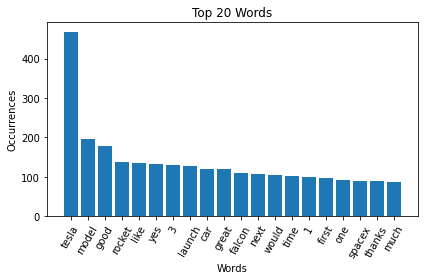

In [15]:
labels, ys = zip(*top_20)
xs = np.arange(len(labels)) 

plt.bar(labels, ys, align='center')
plt.xticks(xs, labels, rotation=60) #Replace default x-ticks with xs, then replace xs with labels
plt.title('Top 20 Words')
plt.xlabel('Words')
plt.ylabel('Occurrences')
plt.tight_layout()

average tweet length: 67.27923686818632


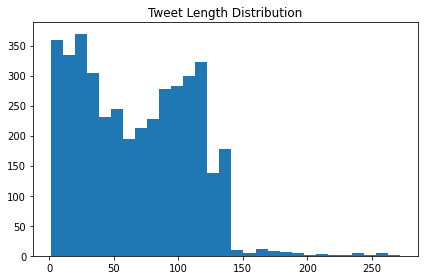

In [16]:
# average length of tweets 
# plot distribution
lens = []
for tweet in tweets:
  lens.append(len(tweet))
plt.hist(lens, bins='auto')
plt.title('Tweet Length Distribution')
plt.tight_layout()
print('average tweet length: {}'.format(np.mean(lens)))

## Prepare for Training

In [17]:
corpus = " ".join(tweets)
corpus = corpus.replace("&amp;", "&")
corpus = corpus.encode("ascii", errors="ignore").decode()
corpus[:200]

'Hi Liz! Thanks to everyone who worked so hard to make Tesla successful. My heart goes out to you. Indeed It was a seriously twisted affair, but alls that ends well. They are, although its kind low-key'

In [18]:
chars = sorted(list(set(corpus)))
vocab_size = len(chars)
print('corpus length: {}'.format((len(corpus))))
print('total chars: {}'.format(vocab_size))

corpus length: 274428
total chars: 89


In [19]:
# create idx2char dict and char2idx dict
char2idx = dict((c, i) for i, c in enumerate(chars))
idx2char = dict((i, c) for i, c in enumerate(chars))

# map corpus to indices
text_as_int = np.array([char2idx[c] for c in corpus])

In [20]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
max_seq_length = 40

# train_ds = create_dataset(BATCH_SIZE, BUFFER_SIZE, train_ds)
# val_ds = create_dataset(BATCH_SIZE, BUFFER_SIZE, val_ds)

In [21]:
tf.compat.v1.reset_default_graph()
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

In [22]:
step = 1
dataX, datay = [], []
# sliding window of shifted over sequences
for i in range(0, len(corpus)-max_seq_length, step):
  seq_in = corpus[i:i+max_seq_length]
  seq_out = corpus[i+max_seq_length]
  dataX.append([char2idx[i] for i in seq_in])
  datay.append(char2idx[seq_out])

n_patterns = len(dataX)
print(n_patterns)

274388


In [23]:
# reshape into one hot encoded vectors
X = [e for lst in dataX for e in lst]
X = keras.utils.to_categorical(X, num_classes=vocab_size)
X = np.reshape(X, (n_patterns, max_seq_length, len(X[0])))
print(X.shape)

# 302599 entries with each entry being 50 by 89
# 50 being sequence length and 89 being size of each one hot encoded vector (vocabulary)

y = keras.utils.to_categorical(datay, num_classes=vocab_size)
y.shape

(274388, 40, 89)


(274388, 89)

In [24]:
# define tf data and batch accordingly
# train val split
data_lstm = tf.data.Dataset.from_tensor_slices((X, y))
data_lstm = data_lstm.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

TRAIN_SIZE = int(0.85 * (n_patterns//BATCH_SIZE))
data_lstm = data_lstm.shuffle(buffer_size= BUFFER_SIZE, reshuffle_each_iteration=False)
train_lstm = data_lstm.take(TRAIN_SIZE)
val_lstm = data_lstm.skip(TRAIN_SIZE)

In [25]:
# https://www.tensorflow.org/guide/data_performance#caching
# cache keeps dataset in memory (so no need for gpu to wait for data to be read)
# prefetch applies preprocessing to next batch in parallel with GPU model fitting 

train_lstm = train_lstm.cache()
#train_lstm = train_lstm.prefetch(tf.data.experimental.AUTOTUNE)

val_lstm = val_lstm.cache()
#val_lstm = val_lstm.prefetch(tf.data.experimental.AUTOTUNE)


## Model Train

In [26]:
def build_lstm(rnn_units, dropout, batch_size):
  lstm = Sequential()
  lstm.add(layers.LSTM(rnn_units, return_sequences=True, batch_input_shape=(batch_size, max_seq_length, vocab_size)))
  lstm.add(layers.Dropout(dropout))
  lstm.add(layers.LSTM(rnn_units))
  lstm.add(layers.Dropout(dropout))
  lstm.add(layers.Dense(vocab_size, activation='softmax'))

  return lstm

lstm = build_lstm(1024, 0.2, BATCH_SIZE)
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (32, 40, 1024)            4562944   
_________________________________________________________________
dropout (Dropout)            (32, 40, 1024)            0         
_________________________________________________________________
lstm_1 (LSTM)                (32, 1024)                8392704   
_________________________________________________________________
dropout_1 (Dropout)          (32, 1024)                0         
_________________________________________________________________
dense (Dense)                (32, 89)                  91225     
Total params: 13,046,873
Trainable params: 13,046,873
Non-trainable params: 0
_________________________________________________________________


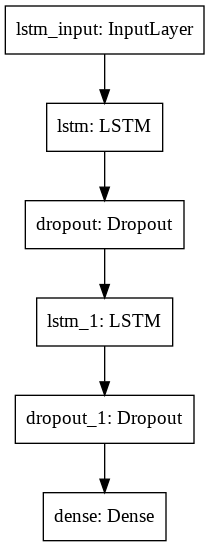

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(lstm, to_file='model.png')

In [28]:
epochs = 20
# def perplexity(labels, preds):
#     return keras.backend.exp(tf.keras.losses.categorical_crossentropy(labels, preds))

# cc takes one hot encoded
def loss(labels, logits):
  return tf.keras.losses.categorical_crossentropy(labels, logits)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4, epsilon=1e-8)
  
lstm.compile(optimizer=optimizer, loss=loss) 

history_lstm = lstm.fit(train_lstm, epochs=epochs, validation_data=val_lstm, verbose=2)

Epoch 1/20
7287/7287 - 246s - loss: 2.3437 - val_loss: 1.9372
Epoch 2/20
7287/7287 - 237s - loss: 1.8061 - val_loss: 1.6073
Epoch 3/20
7287/7287 - 237s - loss: 1.5812 - val_loss: 1.4487
Epoch 4/20
7287/7287 - 237s - loss: 1.4201 - val_loss: 1.3296
Epoch 5/20
7287/7287 - 237s - loss: 1.2662 - val_loss: 1.2323
Epoch 6/20
7287/7287 - 237s - loss: 1.1179 - val_loss: 1.1623
Epoch 7/20
7287/7287 - 237s - loss: 0.9826 - val_loss: 1.1035
Epoch 8/20
7287/7287 - 237s - loss: 0.8747 - val_loss: 1.0566
Epoch 9/20
7287/7287 - 237s - loss: 0.7915 - val_loss: 1.0325
Epoch 10/20
7287/7287 - 237s - loss: 0.7329 - val_loss: 1.0063
Epoch 11/20
7287/7287 - 237s - loss: 0.6854 - val_loss: 1.0073
Epoch 12/20
7287/7287 - 237s - loss: 0.6537 - val_loss: 0.9915
Epoch 13/20
7287/7287 - 237s - loss: 0.6275 - val_loss: 0.9890
Epoch 14/20
7287/7287 - 237s - loss: 0.6094 - val_loss: 0.9902
Epoch 15/20
7287/7287 - 237s - loss: 0.5914 - val_loss: 0.9887
Epoch 16/20
7287/7287 - 237s - loss: 0.5765 - val_loss: 0.9632
E

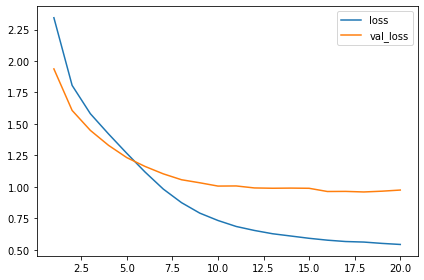

In [29]:
# visualize loss
plt.plot(range(1, epochs+1), history_lstm.history['loss'], label='loss')
plt.plot(range(1, epochs+1), history_lstm.history['val_loss'], label='val_loss')
plt.legend()
plt.tight_layout()

## Generate Text

In [30]:
lstm.save_weights('lstm_weights.hdf5')
# build model of batch 1 for evaluation
lstm1 = build_lstm(1024, 0.2, 1)
lstm1.load_weights('lstm_weights.hdf5')

In [31]:
# sourced from keras tutorial
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [32]:
# generating w/ random start index
# temperature indicates how 'surprised' we are to see the next word
# lower the temperature the more surprising the text
# https://cs.stackexchange.com/questions/79241/what-is-temperature-in-lstm-and-neural-networks-generally
start_index = random.randint(0, len(corpus) - max_seq_length - 1)
for temperature in np.arange(0.25, 1.25, 0.25):
  generated = ''
  sentence = corpus[start_index:start_index+max_seq_length]
  if temperature == 0.25:
    print('generating with: ' + sentence)
  generated += sentence
  print(temperature)
  for i in range(100):
    test = [char2idx[i] for i in sentence]
    test = keras.utils.to_categorical(test, num_classes=vocab_size)
    test = tf.expand_dims(test, 0)
    preds = lstm1.predict(test)[0]
    next_index = sample(preds, temperature)
    next_char = idx2char[next_index]
    sentence = sentence[1:] + next_char
    generated += next_char

  print(generated)

generating with: n In expendable mode, Falcon Heavy can s
0.25
n In expendable mode, Falcon Heavy can send a malion on the should be powered by a visit to see what it was good & have to be fact game-chan
0.5
n In expendable mode, Falcon Heavy can send a manium on hold dragon winds everything has less than the Space Station Searching Wow, this mat
0.75
n In expendable mode, Falcon Heavy can send read right has been the some killed before ok No planmon through the atterot of Nived landed If 
1.0
n In expendable mode, Falcon Heavy can send roll. Back for Reu AMM Good drone ship OC, engauring Tesla Batter Answer by Autopilot Dragon 202


In [33]:
def elon_bot(start_string):
  for temperature in np.arange(0.25, 1.25, 0.25): 
    print('temperature: {}'.format(temperature))
    loop_string = start_string 
    generated = start_string
    for i in range(100):
      start_tokens = [char2idx[i] for i in loop_string]
      pad = max_seq_length - len(start_tokens)
      if pad > 0:
        start_tokens = [0] * pad + start_tokens   
      else:
        start_tokens = start_tokens[:max_seq_length]
      x = keras.utils.to_categorical(start_tokens, num_classes=vocab_size)
      x = tf.expand_dims(x, 0)
      preds = lstm1.predict(x)[0]
      next_index = sample(preds, temperature)
      next_char = idx2char[next_index]
      loop_string = loop_string[1:] + next_char
      generated += next_char

    print(generated)

In [42]:
elon_bot('Hello world.')

temperature: 0.25
Hello world. Thanks tomorrow and make is 300 days are of themmout of companies well true! Tesla Model 3 coming s
temperature: 0.5
Hello world. Hisnese companies (seeit)) Exactly the Shack Same world if we have the memes astan for real with co
temperature: 0.75
Hello world. Thanks tomorrow music use that properes 1 preserved in TX Love someone hold adeaded Model X huse th
temperature: 1.0
Hello world. Promacing SpaceX & Starship will go) Yeslop (arthing serrice is design) Good Yora Sell Just wonted 


In [35]:
# some favorite generated texts
'It is all for rocket now'
'Tesla was wild. That was a pickup truck.'
'Hello world. Development. This will be fine. No technology, so they so no sense.'

'Hello world. Development. This will be fine. No technology, so they so no sense.'

## Karpathy Char RNN w/ attention


In [36]:
data_xd = tf.data.Dataset.from_tensor_slices((dataX, y))
data_xd = data_xd.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [37]:
# from Max Woolf's textgenrnn https://github.com/minimaxir/textgenrnn
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import backend as K
from tensorflow.keras import initializers


class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for
    a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 trainable=True,
                                 initializer=self.init)
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0],
                                                   input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [38]:
input=layers.Input(shape=(max_seq_length,) )
embedded=layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=max_seq_length, batch_size=32)(input)
encoded1=layers.LSTM(128, return_sequences=True)(embedded)
encoded2=layers.LSTM(128, return_sequences=True)(encoded1)
merged = tf.keras.layers.concatenate([embedded] + [encoded1, encoded2])
attention = AttentionWeightedAverage(name='attention')(merged)
output = layers.Dense(vocab_size, activation='softmax')(attention)
model = Model(inputs=[input], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      8900        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 40, 128)      117248      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 40, 128)      131584      lstm_4[0][0]                     
______________________________________________________________________________________________

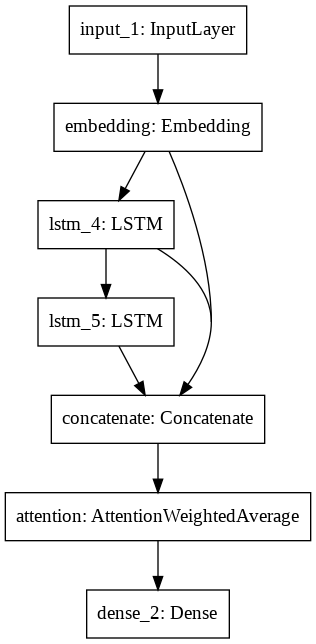

In [39]:
plot_model(model, to_file='model.png')

In [40]:
model.compile(optimizer='adam', loss=loss) 
his = model.fit(data_xd, epochs=20)

Epoch 1/20
8574/8574 [==============================] - 63s 7ms/step - loss: 3.1872
Epoch 2/20
8574/8574 [==============================] - 60s 7ms/step - loss: 2.3196
Epoch 3/20
8574/8574 [==============================] - 60s 7ms/step - loss: 1.9743
Epoch 4/20
8574/8574 [==============================] - 60s 7ms/step - loss: 1.7967
Epoch 5/20
8574/8574 [==============================] - 60s 7ms/step - loss: 1.6959
Epoch 6/20
8574/8574 [==============================] - 60s 7ms/step - loss: 1.6312
Epoch 7/20
8574/8574 [==============================] - 60s 7ms/step - loss: 1.5801
Epoch 8/20
8574/8574 [==============================] - 60s 7ms/step - loss: 1.5423
Epoch 9/20
8574/8574 [==============================] - 60s 7ms/step - loss: 1.5088
Epoch 10/20
8574/8574 [==============================] - 60s 7ms/step - loss: 1.4803
Epoch 11/20
8574/8574 [==============================] - 60s 7ms/step - loss: 1.4546
Epoch 12/20
8574/8574 [==============================] - 61s 7ms/step - lo

In [41]:
model.save_weights('karpathy.hdf5')


## References:

*   Tensorflow Text Generation Tutorial: https://www.tensorflow.org/tutorials/text/text_generation
*   Keras Character Text Gen Tutorial: https://keras.io/examples/generative/lstm_character_level_text_generation/
* Max Woolf's textgenrnn https://github.com/minimaxir/textgenrnn
* https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/ 
* https://cs.stackexchange.com/questions/79241/what-is-temperature-in-lstm-and-neural-networks-generally

